In [120]:
import time
import copy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

In [759]:
class ShortestPath:
    def __init__(self,adjacency_list,is_directed,start,finish,path = None):
        
        self.adjacency_list = copy.deepcopy(adjacency_list)
        if not is_directed:
            for k1 in self.adjacency_list:
                for k2 in self.adjacency_list:
                    if k1 in self.adjacency_list[k2]:
                        self.adjacency_list[k1][k2] = self.adjacency_list[k2][k1]
                        
        self.is_directed = is_directed
        
        for k in self.adjacency_list:
            for v in self.adjacency_list[k]:
                if type(self.adjacency_list[k][v]) is not dict:
                    self.adjacency_list[k][v] = {'weight':self.adjacency_list[k][v]}
        self.start = start
        self.finish = finish
        
        if path is None:
            p = list(self.adjacency_list.keys())
            p.remove(self.start)
            self.dna = np.append(self.start,np.random.permutation(p))
        else:
            self.dna = np.array(path)
            
        
        if self.finish not in self.dna:
            self.fitness = float('inf')
        else:
            length = 0
            for i in range(len(self.dna)-1):
                if self.dna[i] == self.finish:
                        break
                if self.dna[i+1] in self.adjacency_list[self.dna[i]]:
                    length += self.adjacency_list[self.dna[i]][self.dna[i+1]]['weight']
                else:
                    length = float('inf')
                    break
            self.fitness = length
        
        
    def mutate(self):
        path = self.dna.copy()
        p = list(self.adjacency_list.keys())
        p.remove(self.start)
        path[np.random.randint(1,len(p)+1)] = np.random.choice(p)
        return ShortestPath(self.adjacency_list,self.is_directed,self.start,self.finish,path) 
    
    
    def recombinate(self,other):
        a,b = sorted(np.random.randint(len(self.adjacency_list)+1,size=2))
        path = self.dna.copy()
        path[a:b] = other.dna[a:b]
        return ShortestPath(self.adjacency_list,self.is_directed,self.start,self.finish,path)
    
    
    def draw_path(self,generation):
        path = [[self.start,self.dna[0]]]
        for i in range(len(self.dna)-1):
            if self.dna[i] == self.finish or self.dna[i+1] not in self.adjacency_list[self.dna[i]]: break
            path += [[self.dna[i],self.dna[i+1]]]
        
        g = nx.Graph(self.adjacency_list)
        layout = nx.spectral_layout(g)
        labels = nx.get_edge_attributes(g, "weight")
        clear_output(wait = True)
        fig, ax = plt.subplots()
        ax.set_title(f'{generation+1} generation')
        nx.draw_networkx(g, layout,ax=ax)
        nx.draw_networkx_edges(g, pos = layout,edgelist=path,edge_color='r',ax=ax)
        nx.draw_networkx_edge_labels(g, pos=layout, edge_labels=labels,ax=ax)
        plt.show()

In [809]:
def search_path(adjacency_list,is_directed,start,finish,generations,pop_size,keep_size,spawn_size,mr=0.5,rr=0.1):
    # создаём начальную популяцию
    pop = np.array([ShortestPath(adjacency_list,is_directed,start,finish) for i in range(pop_size)],dtype='object')
    
    history = np.empty((0,2,pop_size),dtype='object')
    
    # цикл обучения
    for i in range(generations):
        
        # спавн случайных точек
        spawn = [ShortestPath(adjacency_list,is_directed,start,finish) for i in range(spawn_size)]
        pop = np.append(pop,spawn)
        
        # мутации и рекомбинации
        for j in range(pop_size+spawn_size):
            if np.random.random() < mr:
                new_pop = pop[j].mutate()
                pop = np.append(pop,new_pop) 
            if np.random.random() < rr:
                new_pop = pop[j].recombinate(pop[np.random.randint(pop_size+spawn_size)])
                pop = np.append(pop,new_pop)
        
        # отбор по fitness
        pop = sorted(pop,key = lambda x: x.fitness)
        pop=pop[:keep_size]
        
        # размножение оставшихся
        if pop_size-keep_size > 0:
            pop = np.append(pop,np.random.choice(a=pop,size=pop_size-keep_size))
        
        history = np.append(history,[[[p.fitness for p in pop],pop]],axis=0)
        
        history[-1,1,0].draw_path(i)
        
    
    fig1, ax1 = plt.subplots()
    ax1.plot(history[:,0,0])
    # plt.show()
    return history

In [599]:
al1 = {0:{2:10,3:1}, 1:{2:8, 3:6}, 2:{3:4}, 3:{}}

In [825]:
al2 = {'a':{'b':5,'d':7},'b':{'c':6,'d':8,'e':7},'c':{'e':9},'d':{'e':8,'f':8},'e':{'g':9,'i':15},
          'f':{'g':5,'h':7},'g':{'h':9,'i':8},'h':{'i':11},'i':{}}

In [760]:
p = ShortestPath(al1,False,0,1,[0,1,1,1])

In [762]:
p1 = ShortestPath(al1,False,0,1,[0,2,2,2])

In [748]:
p1 = p.mutate()
p1.dna

array([0, 2, 2, 3])

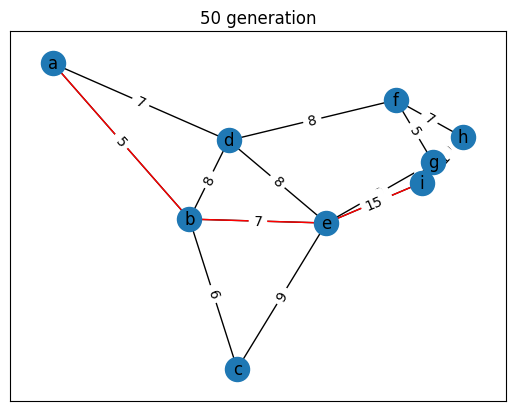

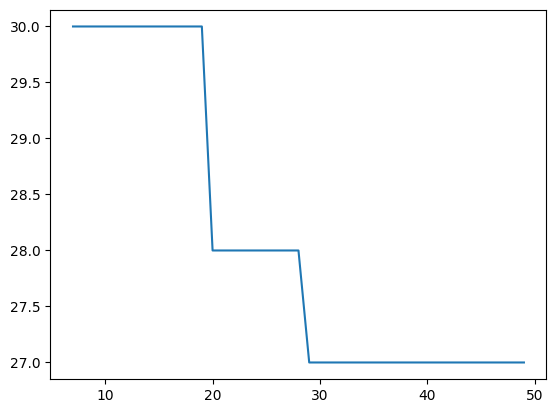

In [829]:
h = search_path(al2,False,'a','i',50,20,20,10)